<a href="https://colab.research.google.com/github/zzzle96/PyTorch/blob/master/20200827/nlp%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
from torchtext import data
from torchtext import datasets
import string
import random
import torch.nn as nn


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

In [57]:
TEXT = data.Field(pad_first = True, fix_length = 500)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)

In [58]:
 print(vars(train_data.examples[0]))

{'text': ['"October', 'Sky"', 'is', 'a', 'film', 'that', 'will', 'steal', 'your', 'heart,', 'fill', 'your', 'mind', 'with', 'vivid', 'imagery,', 'and', 'lift', 'your', 'spirit.', 'The', 'tale', 'of', 'Homer', 'Hickham', 'and', 'his', 'dream', 'of', 'creating', 'a', 'rocket', 'seem', 'so', 'simple', 'at', 'first,', 'especially', 'when', 'the', 'film', 'is', 'set', 'in', 'a', 'mining', 'town,', 'where', 'the', 'future', 'is', 'as', 'clear', 'cut', 'as', 'the', 'lumps', 'of', 'coal', 'in', 'the', 'mine.', 'But', 'Homer', 'cannot', 'follow', 'in', 'his', "father's", 'footsteps.', 'With', 'the', 'encouragement', 'of', 'Miss', 'Riley,(a', 'friendly', 'teacher),', 'members', 'of', 'his', "father's", 'staff,', 'and', 'his', 'friends,', 'Homer', 'attempts', 'to', 'make', 'his', 'dream', 'a', 'reality.<br', '/><br', '/>Yet', 'as', 'in', 'any', 'true', 'to', 'life', 'story,', 'there', 'are', 'many', 'stops', 'along', 'the', 'way.', 'Director', 'Joe', 'Johnston', 'lowers', 'us', 'into', 'the', 'co

In [59]:
for example in train_data.examples:
  text = [x.lower() for x in vars(example)['text']]
  text = [x.replace("<br","") for x in text]
  text = [''.join(c for c in s if c not in string.punctuation) for s in text]
  text = [s for s in text if s]
  vars(example)['text'] = text

for example in test_data.examples:
  text = [x.lower() for x in vars(example)['text']]
  text = [x.replace("<br","") for x in text]
  text = [''.join(c for c in s if c not in string.punctuation) for s in text]
  text = [s for s in text if s]
  vars(example)['text'] = text

In [60]:
train_data, valid_data = train_data.split(random_state = random.seed(0), split_ratio = 0.8)

In [61]:
TEXT.build_vocab(train_data,max_size = 50000)
LABEL.build_vocab(train_data)

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.manual_seed(777)                                      
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [63]:
batch_size = 100

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data,valid_data, test_data),
    batch_size = batch_size,
    device = device)


In [64]:
class Sentiment(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers,
               dropout, method):
    super().__init__()

    self.method = method

    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout)
    self.gru =  nn.GRU(embed_dim, hidden_dim, n_layers, dropout = dropout)
    self.fc = nn.Linear(hidden_dim*n_layers, output_dim)
    self.drop = nn.Dropout(dropout)

  def forward(self,x):

    emb = self.drop(self.embed(x))

    if(self.method == 'LSTM'):
      out, (h,c) = self.lstm(emb)
      h = self.drop(torch.cat((h[-2,:,:],h[-1,:,:]),dim = 1))

    if(self.method == 'GRU'):
      out,h = self.gru(emb)
      h = self.drop(torch.cat((h[-2,:,:],h[-1,:,:]),dim = 1))

    return self.fc(h.squeeze(0))


    

In [65]:
def binary_accuracy(preds,y):

  rounded_preds = torch.round(torch.sigmoid(preds))
  correct = (rounded_preds ==y).float()
  acc = correct.sum()/len(correct)
  return acc

In [66]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for batch in iterator:

    optimizer.zero_grad()

    predictions = model(batch.text).squeeze(1)
    loss = criterion(predictions, batch.label)
    acc = binary_accuracy(predictions, batch.label)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)


In [67]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()
  with torch.no_grad():

    for batch in iterator:

      predictions = model(batch.text).squeeze(1)
      loss = criterion(predictions, batch.label)
      acc = binary_accuracy(predictions, batch.label)

      epoch_loss += loss.item()
      epoch_acc += acc.item()

    return epoch_loss/ len(iterator), epoch_acc/len(iterator)
    

In [68]:
input_dim = len(TEXT.vocab)
embed_dim = 400
hidden_dim = 256
output_dim = 1
n_layers = 2
dropout = 0.5

model = Sentiment(input_dim, embed_dim, hidden_dim, output_dim, n_layers, dropout, method = 'LSTM').to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)

In [ ]:
N_EPOCHS = 10
epochss = []
loss = []
for epoch in range(N_EPOCHS):

  train_loss, train_acc = train(model,train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model,valid_iterator, criterion)

  epochss.append(epoch+1)
  loss.append(train_loss)

  print('epoch: {:02}     train loss: {:.3f}   val loss: {:.3f} '
        .format(epoch+1,train_loss, valid_loss))

epoch: 01     train loss: 0.654   val loss: 0.564 


In [49]:
test_loss, test_acc = evaluate(model,test_iterator, criterion)
print('Test Acc L {:.2f}%'.format(test_acc*100))

Test Acc L 85.38%


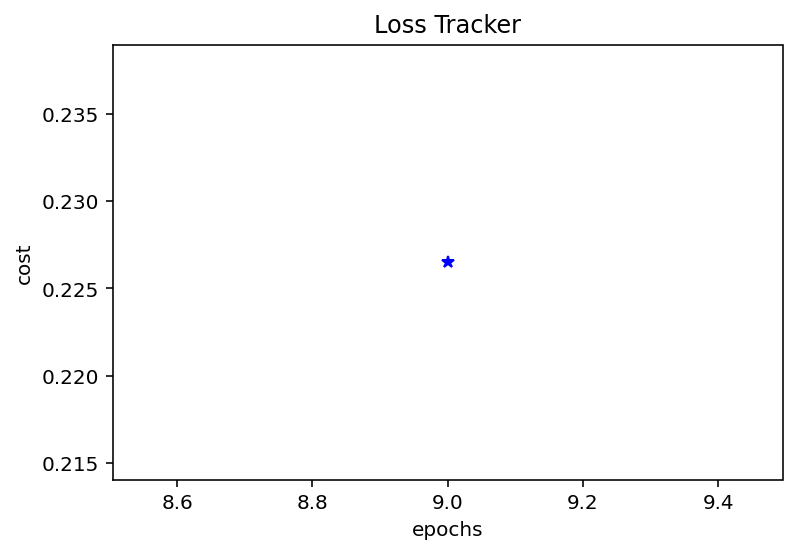

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
plt.plot(torch.Tensor([epochss]),torch.Tensor([loss]), 'b*-')

plt.title('Loss Tracker')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()